# Acoustic-optic effect analysis

In [1]:
%load_ext autoreload
%load_ext usnm2p.skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import os
import jupyter_slack
import datetime
from scipy.stats import pearsonr

# Internal modules
from usnm2p.logger import logger
from usnm2p.constants import *
from usnm2p.utils import *
from usnm2p.fileops import *
from usnm2p.postpro import *
from usnm2p.plotters import *
from usnm2p.batchutils import *
from usnm2p.indexers import FrameIndexer

# Root directory for output figures
figsdir = get_data_root(kind=DataRoot.FIG)  
logger.info(f'output figures directory: "{figsdir}"')

# Figures dictionary
figs = {}

 2025/10/06 11:50:25: output figures directory: "/Users/tlemaire/Documents/data/usnm/figs"


### Input datasets and main processing parameters

In [3]:
analysis_type = 'main'  # Analysis type
mouseline = 'sst'  # Mouse line
slack_notify = False  # Whther to send slack notificaiton upon completion 
show_processing_steps = False  # whether to show intermediate processing steps 

### Derived parameters

In [4]:
group_key, group_refval = {  # Grouping variable and reference value for the analysis
    'main': (Label.ISPTA, 0.),
    'offset': (Label.OFFSET, 2.0),
}[analysis_type]
refcolor = Palette.LINE[mouseline] # Reference color for the plot

skip_processing_steps = not show_processing_steps

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{mouseline} {analysis_type} intraframe analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 2025/10/06 11:50:25: sst main intraframe analysis notebook started on 2025-10-06 at 11:50:25


### Load and organize data

In [5]:
# Get data directory
dataroot = get_data_root(kind=DataRoot.ROWAVG)
datadir = os.path.join(dataroot, analysis_type, mouseline)
logger.info(f'input data directory: {datadir}')

# List data files
datafiles = sorted([f for f in os.listdir(datadir) if f.endswith('.h5')])

# For each input file
trialagg_dFF, Fbase, stim_mask, stim_evoked_dFF, info_table = {}, {}, {}, {}, {}
for fname in datafiles:
    # Parse dataset ID from file name
    dataset_ID = os.path.splitext(fname)[0]
    
    # Load dFF data and info table
    dFF, Fb, smask, sedFF, table = load_rowavg_dataset(os.path.join(datadir, fname))
    
    # If no baseline data, skip this dataset
    if group_key == Label.ISPTA and not any(table[Label.P] == 0.):
        logger.warning(f'no data for P = 0 in {dataset_ID} -> skipping')
        continue
    
    # Restrict data to non-duplicated runs
    codefunc = get_param_code if group_key == Label.ISPTA else get_offset_code
    iruns = codefunc(table).drop_duplicates(keep='first').index.values
    mux_slice = get_mux_slice(dFF.index)
    mux_slice[0] = iruns
    dFF = dFF.loc[tuple(mux_slice)]
    mux_slice = get_mux_slice(Fb.index)
    mux_slice[0] = iruns
    Fb = Fb.loc[tuple(mux_slice)]
    smask = smask.loc[tuple(mux_slice)]
    sedFF = sedFF.loc[tuple(mux_slice)]
    table = table.loc[iruns]

    # Average dFF data across trials, and add to dictionary
    logger.info('computing trial-average dFF profiles')
    trialagg_dFF[dataset_ID] = dFF.groupby([Label.RUN, Label.FRAME, Label.ROW]).mean()
    Fbase[dataset_ID] = Fb
    stim_mask[dataset_ID] = smask
    stim_evoked_dFF[dataset_ID] = sedFF
    info_table[dataset_ID] = table

# Assemble data dictionaries into run-indexed pandas structures
logger.info(f'assembling and sorting data structures...')
trialagg_dFF = pd.concat(trialagg_dFF, axis=0, names=[Label.DATASET]).sort_index()
Fbase = pd.concat(Fbase, axis=0, names=[Label.DATASET]).sort_index()
stim_mask = pd.concat(stim_mask, axis=0, names=[Label.DATASET]).sort_index()
stim_evoked_dFF = pd.concat(stim_evoked_dFF, axis=0, names=[Label.DATASET]).sort_index()
info_table = pd.concat(info_table, axis=0, names=[Label.DATASET]).sort_index()

# Extract constant parameters from info table
PRF = get_singleton(info_table, Label.PRF)
dur = get_singleton(info_table, Label.DUR)
fps = get_singleton(info_table, Label.FPS)
lpf = get_singleton(info_table, Label.LPF)
nframes_per_trial = get_singleton(info_table, Label.NPERTRIAL)
npulses = int(dur * PRF)

# Add relevant columns to info table
if group_key == Label.ISPTA:
    # For main analysis, add ISPTA and ISPPA columns
    info_table = add_intensity_to_table(info_table, precision=2)

    # Determine keys to add to trialagg_dFF
    exp_keys = [Label.P, Label.DC, Label.ISPPA, group_key]

elif group_key == Label.OFFSET:
    # For offset analysis, add transducer XY coordinates and offsets
    logger.info('parsing transducer XY offset coordinates...')
    offsets_2d = get_offset_complex(info_table)
    info_table['xoff (mm)'] = offsets_2d.apply(np.real)
    info_table['yoff (mm)'] = offsets_2d.apply(np.imag)
    xykeys = ['xoff (mm)', 'yoff (mm)']
    info_table[Label.OFFSET] = np.linalg.norm(info_table[xykeys], axis=1).round(2)

    # Determine keys to add to trialagg_dFF
    exp_keys = [Label.SUFFIX, *xykeys, group_key]

# Extract stimulus onset time from info table, and construct FrameIndexer
tref = get_stim_onset_time(mouseline)
fidx = FrameIndexer.from_time(tref, TPRE, TPOST, 1 / fps, npertrial=nframes_per_trial)

# Subtract pre-stimulus baseline levels for each dataset and run
logger.info('subtracting pre-stimulus baseline levels')
gby = [Label.DATASET, Label.RUN]
trialagg_dFF = trialagg_dFF.groupby(gby).transform(
    lambda y: y - y.droplevel(gby).loc[:fidx.iref].median())

# Add relevant columns to trialagg_dFF
trialagg_dFF = free_expand_and_add(info_table[exp_keys], trialagg_dFF.to_frame())

# Remove data for DC = 1%, if present
if Label.DC in trialagg_dFF.columns:
    logger.info('removing data for DC = 1%')
    toremove = info_table[info_table[Label.DC] == 1.0].index
    trialagg_dFF = trialagg_dFF.drop(toremove)
    Fbase = Fbase.drop(toremove)
    stim_mask = stim_mask.drop(toremove) 
    stim_evoked_dFF = stim_evoked_dFF.drop(toremove)
    info_table = info_table.drop(toremove)

# Harmonize run indexes across datasets
dfs = {
    'trialagg_dFF': trialagg_dFF,
    'Fbase': Fbase,
    'stim_mask': stim_mask,
    'stim_evoked_dFF': stim_evoked_dFF,
}
dfs = {k: expand_and_add(info_table[exp_keys], df) for k, df in dfs.items()}
dfs['info_table'] = info_table
dfs = harmonize_run_index(dfs, condition='param' if group_key == Label.ISPTA else 'offset')
trialagg_dFF, Fbase, stim_mask, stim_evoked_dFF, info_table = [df.sort_index() for df in dfs.values()]

# Extract run index corresponding to reference condition
if group_key == Label.ISPTA:
    # For param-dep dataset, reference condition = 0.8 MPa, 50% DC  
    refcond = np.logical_and(info_table[Label.P] == P_REF, info_table[Label.DC] == DC_REF)
else:
    # For offset dataset, reference condition = zero-offset
    refcond = info_table[Label.OFFSET] == 0.
irun_refcond = info_table[refcond].index.unique(Label.RUN)[0]

# Create a mapping from grouping variable to DC
col_DC_map = info_table.groupby(group_key).first()[Label.DC]
if group_key == Label.ISPTA:  # Set DC = 0 for ISPTA = 0
    col_DC_map.loc[0.] = 0.

# Add serialized "frame-row" index column to trialagg_dFF
logger.info('adding serialized "frame-row" index column')
iframe = trialagg_dFF.index.get_level_values(Label.FRAME)
irow = trialagg_dFF.index.get_level_values(Label.ROW)
trialagg_dFF[Label.FRAMEROW] = iframe * lpf + irow

# Add time vector to trial-aggregated dFF
expfidx = fidx.resample(lpf)
add_time_to_table(trialagg_dFF, fidx=expfidx, idxkey=Label.FRAMEROW, fps=fps * lpf)

trialagg_dFF

 2025/10/06 11:50:25: input data directory: /Users/tlemaire/Documents/data/usnm/rowavg/main/sst
 2025/10/06 11:50:25: loading row-average dFF data from 20190510_mouse6_region1.h5
 2025/10/06 11:50:26: loading pixel-wise baseline fluroescence frames
 2025/10/06 11:50:26: lpading stimulus masks
 2025/10/06 11:50:26: loading pixel-wise stim-evoked dFF change
 2025/10/06 11:50:26: loading experiment info table
 2025/10/06 11:50:26: computing trial-average dFF profiles
 2025/10/06 11:50:26: loading row-average dFF data from 20190510_mouse6_region2.h5
 2025/10/06 11:50:26: loading pixel-wise baseline fluroescence frames
 2025/10/06 11:50:26: lpading stimulus masks
 2025/10/06 11:50:26: loading pixel-wise stim-evoked dFF change
 2025/10/06 11:50:26: loading experiment info table
 2025/10/06 11:50:26: computing trial-average dFF profiles
 2025/10/06 11:50:27: loading row-average dFF data from 20190511_mouse7_region1.h5
 2025/10/06 11:50:27: loading pixel-wise baseline fluroescence frames
 2025

ΔF/F0  P (MPa)  DC (%)  \
dataset                 run frame row                              
20190510_mouse6_region1 0   0     0   -0.091794      0.0    50.0   
                                  1   -0.091916      0.0    50.0   
                                  2   -0.096531      0.0    50.0   
                                  3   -0.093135      0.0    50.0   
                                  4   -0.093136      0.0    50.0   
...                                         ...      ...     ...   
20190808_mouse8_region1 14  99    251 -0.012704      0.8    80.0   
                                  252 -0.012713      0.8    80.0   
                                  253 -0.010329      0.8    80.0   
                                  254 -0.008939      0.8    80.0   
                                  255 -0.008551      0.8    80.0   

                                       I_SPPA (W/cm2)  I_SPTA (W/cm2)  \
dataset                 run frame row                                   
20190510_mouse6_region1 0   0     0              0.00            0.00   
                                  1              0.00            0.00   
                                  2              0.00            0.00   
                                  3              0.00            0.00   
                                  4              0.00            0.00   
...                                               ...             ...   
20190808_mouse8_region1 14  99    251           19.78           15.83   
                                  252           19.78           15.83   
                                  253           19.78           15.83   
                                  254           19.78           15.83   
                                  255           19.78           15.83   

                                       frame row   time (s)  
dataset                 run frame row                        
20190510_mouse6_region1 0   0     0            0  -2.808989  
                                  1            1  -2.807892  
                                  2            2  -2.806794  
                                  3            3  -2.805697  
                                  4            4  -2.804600  
...                                          ...        ...  
20190808_mouse8_region1 14  99    251      25595  25.275413  
                                  252      25596  25.276510  
                                  253      25597  25.277607  
                                  254      25598  25.278704  
                                  255      25599  25.279802  

[5171200 rows x 7 columns]

### Plot frames for reference condition

 2025/10/06 11:51:11: plotting sst - pixel-wise stimulus mask frames by dataset
 2025/10/06 11:51:11: plotting sst - pixel-wise baseline fluorescence frames by dataset
 2025/10/06 11:51:12: plotting sst - pixel-wise stim-evoked dFF frames by dataset


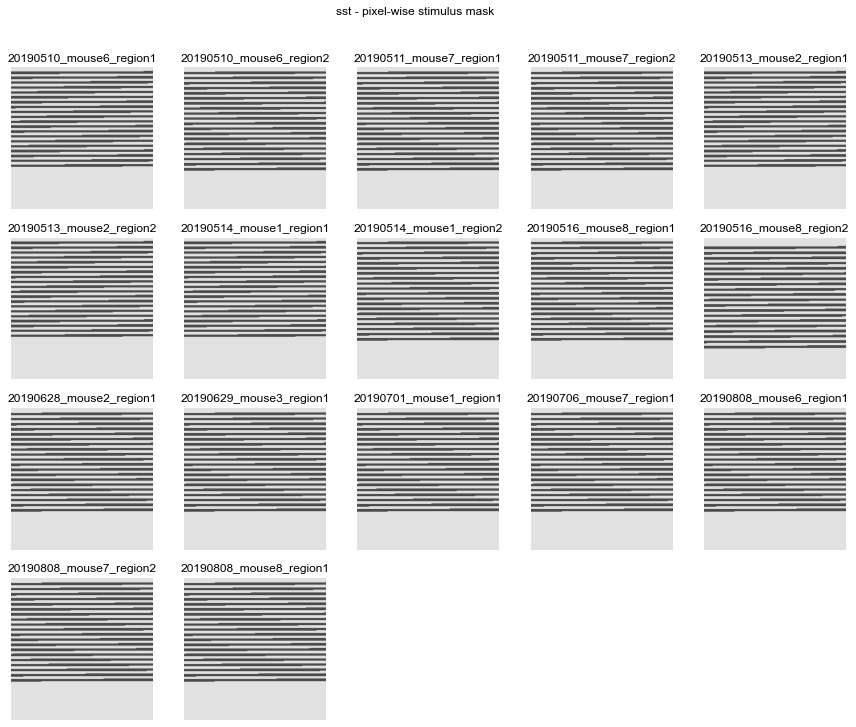

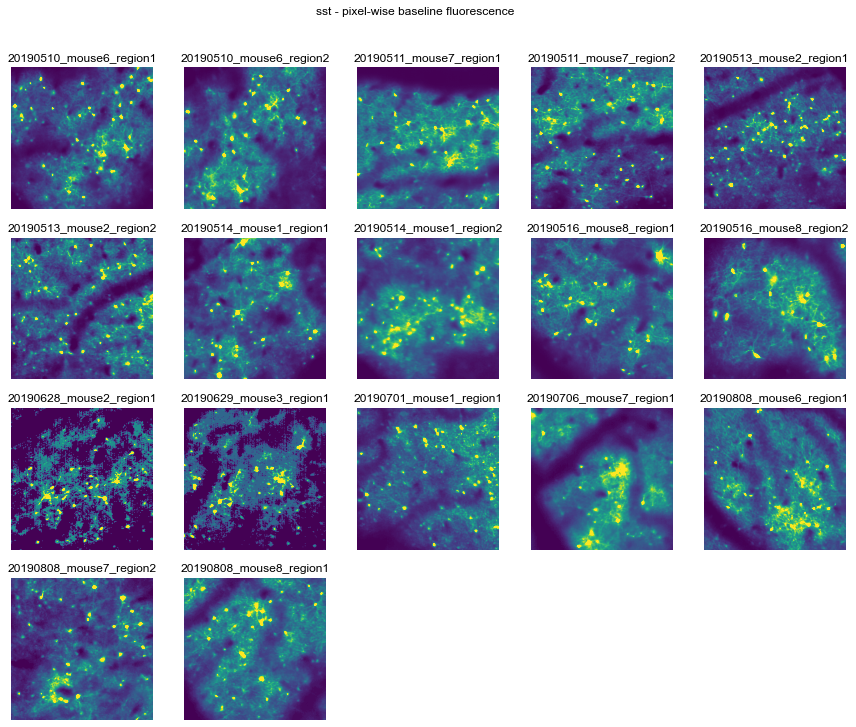

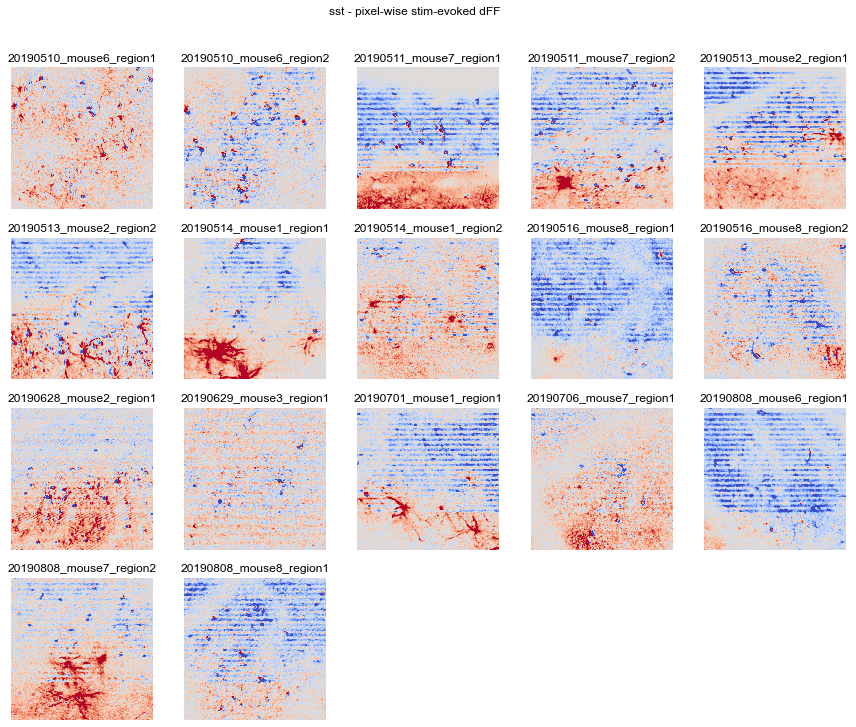

In [6]:
framesdict = {
    'stimulus mask': (stim_mask, None),
    'baseline fluorescence': (Fbase, .99),
    'stim-evoked dFF': (stim_evoked_dFF, .95)
}
for k, (df, qmax) in framesdict.items():
    title = f'{mouseline} - pixel-wise {k}'
    figs[title] = plot_frames(
        df.loc[pd.IndexSlice[:, irun_refcond], np.arange(lpf)],
        Label.DATASET,
        qmax=qmax,
        title=title
    )

### Define plot parameters

In [7]:
# Restrict time bounds for plotting 
tbounds = {
    'default': (-1, 5),  # Default time bounds
    'zoomed': (-0.1, 0.3)  # Time bounds around stimulus
}
if skip_processing_steps:
    del tbounds['default']

# Common plot parameters
pltkwargs = {
    'col': group_key,
    'col_DC_mapper': col_DC_map,
    'stimdur': dur,
    'stimPRF': PRF,
    'fps': fps,
    'stimdelay': DEFAULT_STIM_TRIG_DELAY,
}

### Plot trial-aggregated dFF vs grouping variable, across datasets (default and zoom-in around stimulus)

 2025/10/06 11:51:15: plotting ΔF/F0 time-varying profile per I_SPTA (W/cm2) between -0.1 and 0.3 s
 2025/10/06 11:51:15: stacking ΔF/F0 profiles by dataset


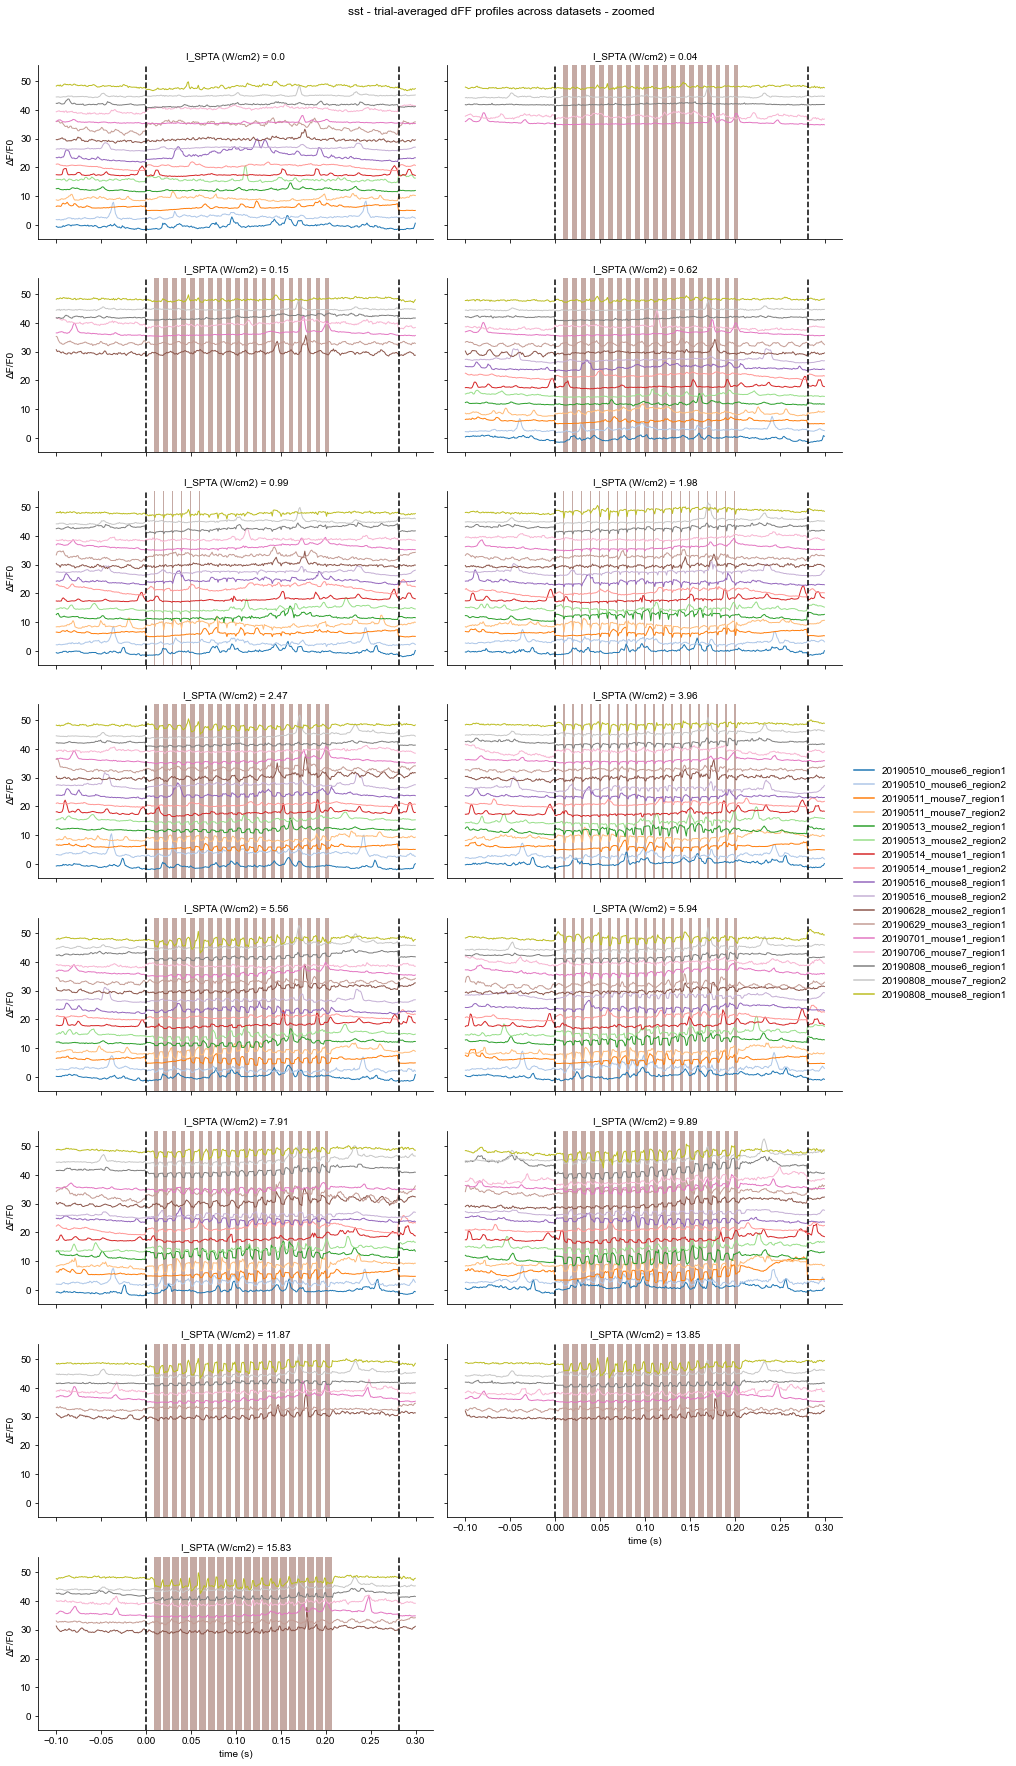

In [8]:
for k, v in tbounds.items():
    title = f'{mouseline} - trial-averaged dFF profiles across datasets - {k}'
    figs[title] = plot_rowagg_profiles(
        trialagg_dFF.copy(), 
        tbounds=v, 
        hue=Label.DATASET,
        stackhue=True,
        color=refcolor,
        addavg=False,
        height=3,
        aspect=2,
        **pltkwargs
    )
    figs[title].suptitle(title, y=1.02)

### Define function to aggregate across datasets

In [9]:
# Define function to aggregate across datasets
def aggregate_across_datasets(data):
    '''
    Aggregate across datasets by averaging dFF columns and 
    keeping first values for other columns.
    '''
    logger.info('computing cross-dataset aggregates')
    agg_funcs = {k: 'mean' if Label.DFF in k else 'first' for k in data.columns}
    gby = [k for k in data.index.names if k not in (Label.DATASET, Label.RUN)]
    return data.groupby([group_key, *gby]).agg(agg_funcs).drop(group_key, axis=1)

### Show only cross-dataset average

In [10]:
%%skip $skip_processing_steps

# Plot cross-dataset average trial-averaged dFF
for k, v in tbounds.items():
    title = f'{mouseline} - trial-averaged dFF profiles (cross-dataset average) - {k}'
    figs[title] = plot_rowagg_profiles(
        aggregate_across_datasets(trialagg_dFF), tbounds=v, color=refcolor, **pltkwargs)
    figs[title].suptitle(title, y=1.02)

# Determine input key for next processing stage
input_ykey = Label.DFF

### Fit and subtract physiological response trend

In [11]:
%%skip $skip_processing_steps

# Interpolate dFF values between the last row of each frame to extract "physiological response trend"
logger.info('interpolating dFF values to extract slow physiological response trend')
resp_ykey = f'{input_ykey} response trend'
trialagg_dFF[resp_ykey] = trialagg_dFF[input_ykey].copy()
trialagg_dFF.loc[trialagg_dFF.index.get_level_values(Label.ROW) != (lpf - 1), resp_ykey] = np.nan
interp_mux = get_mux_slice(trialagg_dFF.index)
interp_mux[-2:] = [0, 0]
interp_mux = tuple(interp_mux)
trialagg_dFF.loc[interp_mux, resp_ykey] = trialagg_dFF.loc[interp_mux, input_ykey]
gby = [Label.DATASET, Label.RUN]
trialagg_dFF[resp_ykey] = (
    trialagg_dFF
    .groupby(gby)
    [resp_ykey]
    .apply(lambda x: x.droplevel(gby).interpolate(method='linear'))
)

# Subtract interpolated response trend from original profile
logger.info('subtracting interpolated response trend from original profile')
resp_corrected_ykey = f'response corrected {input_ykey}'
trialagg_dFF[resp_corrected_ykey] = trialagg_dFF[input_ykey] - trialagg_dFF[resp_ykey]

# Plot 
for k, v in tbounds.items():
    title = f'{mouseline} - response detrending - {k}'
    figs[title] = plot_rowagg_profiles(
        aggregate_across_datasets(trialagg_dFF),
        ykey=[input_ykey, resp_ykey, resp_corrected_ykey],
        color=[refcolor, 'C2', 'C4'],
        tbounds=v, 
        errorbar=None,
        **pltkwargs
    )
    figs[title].suptitle(title, y=1.02)

# Determine input key for next processing stage
input_ykey = resp_corrected_ykey

### Predict and subtract expected "scanning artifact"

In [12]:
%%skip $skip_processing_steps

# Compute average intra-frame variation (scanning artifact) profile from 3 preceding frames
npre = 3
logger.info(f'computing intra-frame variation profile (scanning artifact) from {npre} preceding frames')
preceding_ibounds = np.array([-npre, -1]) + fidx.iref

# Average across cycles
logger.info('averaging across cycles to get predictive "scanning artifact" profile')
ypreavg = (trialagg_dFF
    .loc[pd.IndexSlice[:, :, preceding_ibounds[0]:preceding_ibounds[1]], input_ykey]
    .groupby([Label.DATASET, Label.RUN, Label.ROW])
    .mean()
)

# Expand average profile across frames dimension to yield "expected" scanning artifact profile
logger.info('expanding "expected" scanning artifact profile along frames dimension')
scanning_artifact_pred_key = f'expected {Label.DFF} scanning artifact'
trialagg_dFF[scanning_artifact_pred_key] = free_expand(ypreavg, trialagg_dFF)

# Subtract expected scanning artifact profile along trial length
logger.info('subtracting expected scanning artifact profile along trial length')
scanning_artifact_corrected_ykey = f'scanning artifact corrected {Label.DFF}'
trialagg_dFF[scanning_artifact_corrected_ykey] = trialagg_dFF[input_ykey] - trialagg_dFF[scanning_artifact_pred_key]

# Plot 
for k, v in tbounds.items():
    title = f'{mouseline} - scanning artifact detrending - {k}'
    figs[title] = plot_rowagg_profiles(
        aggregate_across_datasets(trialagg_dFF),
        ykey=[input_ykey, scanning_artifact_pred_key, scanning_artifact_corrected_ykey],
        color=[refcolor, 'C2', 'C4'],
        tbounds=v, 
        errorbar=None,
        **pltkwargs
    )
    figs[title].suptitle(title, y=1.02)

# Determine input key for next processing stage
input_ykey = scanning_artifact_corrected_ykey

### Fit and remove remaining LF baseline for each individual frame

In [13]:
%%skip $skip_processing_steps

# Apply frame-by-frame rolling filter to extract baseline
logger.info('applying frame-by-frame rolling filter to extract remaining intra-frame LF baseline')
bfit_key = f'frame-by-frame LF baseline fit {input_ykey}'
wt = 15e-3  # Rolling window size (in s)
w = int(np.round(wt * fps * lpf))  # Rolling window size (in frames)
if w % 2 == 0:  # Ensure odd window size
    w += 1
def bfunc(y):
    return gaussian_filter1d(quantile_filter(y, w, 1), w // 2)
trialagg_dFF[bfit_key] = (trialagg_dFF
    .groupby([Label.DATASET, Label.RUN, Label.FRAME])
    [input_ykey]
    .transform(lambda y: gaussian_filter1d(quantile_filter(y.values, w, 1), w // 2))
    .values
)

# Subtract frame-by-frame baseline fit from baseline corrected profile
logger.info('subtracting frame-by-frame baseline fit from baseline corrected profile')
bcorr_key = f'frame-by-frame LF baseline corrected {input_ykey}'
trialagg_dFF[bcorr_key] = trialagg_dFF[input_ykey] - trialagg_dFF[bfit_key]

# Plot 
for k, v in tbounds.items():
    title = f'{mouseline} - remaining intra-frame LF baseline detrending - {k}'
    figs[title] = plot_rowagg_profiles(
        aggregate_across_datasets(trialagg_dFF),
        ykey=[input_ykey, bfit_key, bcorr_key],
        color=[refcolor, 'C2', 'C4'],
        tbounds=v, 
        errorbar=None,
        **pltkwargs
    )
    figs[title].suptitle(title, y=1.02)

# Determine input key for next processing stage
input_ykey = bcorr_key

### Plot final corrected profiles around stimulus window

 2025/10/06 11:51:20: processing intraframe fluorescence signal across ['dataset', 'run'] combinations
 2025/10/06 11:51:32: computing cross-dataset aggregates
 2025/10/06 11:51:33: plotting ['ΔF/F0', 'processed ΔF/F0'] time-varying profile per I_SPTA (W/cm2) between -0.1 and 0.3 s


Text(0.5, 1.02, 'sst - final corrected dFF')

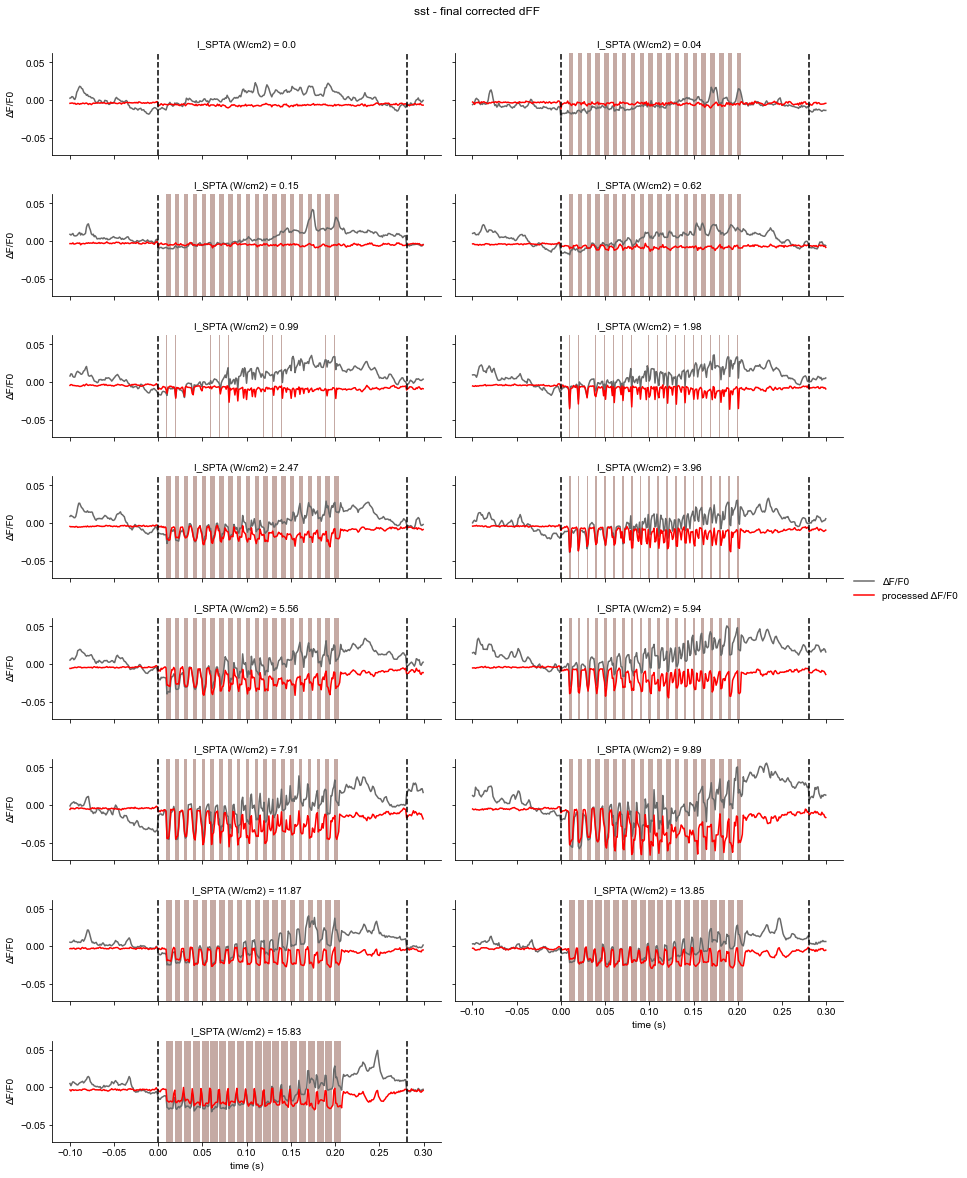

In [14]:
# Wrap entire process in 1 function
processed_ykey = f'processed {Label.DFF}'
trialagg_dFF[processed_ykey] = process_intraframe_fluorescence(
    trialagg_dFF[Label.DFF].copy(),
    fidx,
    fps
)

# Plot corrected signal around stimulus (comparing extended and function-wrapped processing)
title = f'{mouseline} - final corrected dFF'
figs[title] = plot_rowagg_profiles(
    aggregate_across_datasets(trialagg_dFF),
    ykey=[Label.DFF, processed_ykey],
    tbounds=tbounds['zoomed'],
    color=['dimgray', refcolor],
    **pltkwargs
)
figs[title].suptitle(title, y=1.02)

### Align signals to common simulus template to compensate for slight variations in trigger delay and sampling rate

 2025/10/06 11:51:37: computing template matching transformation parameters per dataset on run 11
 2025/10/06 11:51:37: matching 256-samples template and signal over (+/-4 samples shift x +/-5% stretch) 2D space
 2025/10/06 11:51:37: matching 256-samples template and signal over (+/-4 samples shift x +/-5% stretch) 2D space
 2025/10/06 11:51:37: matching 256-samples template and signal over (+/-4 samples shift x +/-5% stretch) 2D space
 2025/10/06 11:51:37: matching 256-samples template and signal over (+/-4 samples shift x +/-5% stretch) 2D space
 2025/10/06 11:51:37: matching 256-samples template and signal over (+/-4 samples shift x +/-5% stretch) 2D space
 2025/10/06 11:51:37: matching 256-samples template and signal over (+/-4 samples shift x +/-5% stretch) 2D space
 2025/10/06 11:51:37: matching 256-samples template and signal over (+/-4 samples shift x +/-5% stretch) 2D space
 2025/10/06 11:51:37: matching 256-samples template and signal over (+/-4 samples shift x +/-5% stretch)

org. corr  opt. corr  shift (samples)  \
dataset                                                          
20190510_mouse6_region1   0.131697   0.230831               -1   
20190510_mouse6_region2   0.537667   0.537667                0   
20190511_mouse7_region1   0.748819   0.748819                0   
20190511_mouse7_region2   0.711530   0.711530                0   
20190513_mouse2_region1  -0.092320   0.835022                1   
20190513_mouse2_region2  -0.057444   0.778721                1   
20190514_mouse1_region1  -0.148808   0.592619                1   
20190514_mouse1_region2   0.785705   0.785705                0   
20190516_mouse8_region1   0.878082   0.878082                0   
20190516_mouse8_region2   0.009216   0.719294                1   
20190628_mouse2_region1   0.689413   0.689413                0   
20190629_mouse3_region1   0.532355   0.532355                0   
20190701_mouse1_region1   0.811943   0.811943                0   
20190706_mouse7_region1   0.746611   0.746611                0   
20190808_mouse6_region1   0.878682   0.878682                0   
20190808_mouse7_region2   0.633697   0.633697                0   
20190808_mouse8_region1   0.867444   0.867444                0   

                         rel. stretch (%)  effective fs (Hz)  offset (ms)  \
dataset                                                                     
20190510_mouse6_region1               2.6         888.265107    -0.001126   
20190510_mouse6_region2               0.0         911.360000     0.000000   
20190511_mouse7_region1               0.0         911.360000     0.000000   
20190511_mouse7_region2               0.0         911.360000     0.000000   
20190513_mouse2_region1               2.9         885.675413     0.001129   
20190513_mouse2_region2               2.9         885.675413     0.001129   
20190514_mouse1_region1               2.8         886.536965     0.001128   
20190514_mouse1_region2               0.0         911.360000     0.000000   
20190516_mouse8_region1               0.0         911.360000     0.000000   
20190516_mouse8_region2              -3.7         946.375909     0.001057   
20190628_mouse2_region1               0.0         911.360000     0.000000   
20190629_mouse3_region1               0.0         911.360000     0.000000   
20190701_mouse1_region1               0.0         911.360000     0.000000   
20190706_mouse7_region1               0.0         911.360000     0.000000   
20190808_mouse6_region1               0.0         911.360000     0.000000   
20190808_mouse7_region2               0.0         911.360000     0.000000   
20190808_mouse8_region1               0.0         911.360000     0.000000   

                         valid  
dataset                         
20190510_mouse6_region1  False  
20190510_mouse6_region2   True  
20190511_mouse7_region1   True  
20190511_mouse7_region2   True  
20190513_mouse2_region1   True  
20190513_mouse2_region2   True  
20190514_mouse1_region1   True  
20190514_mouse1_region2   True  
20190516_mouse8_region1   True  
20190516_mouse8_region2   True  
20190628_mouse2_region1   True  
20190629_mouse3_region1   True  
20190701_mouse1_region1   True  
20190706_mouse7_region1   True  
20190808_mouse6_region1   True  
20190808_mouse7_region2   True  
20190808_mouse8_region1   True

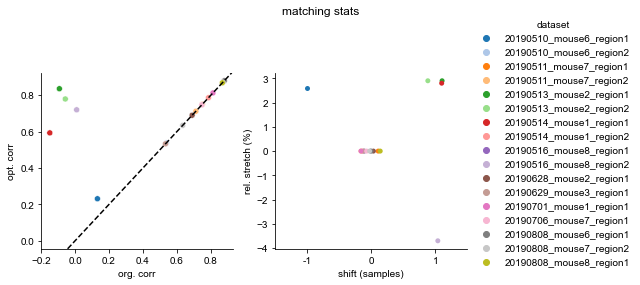

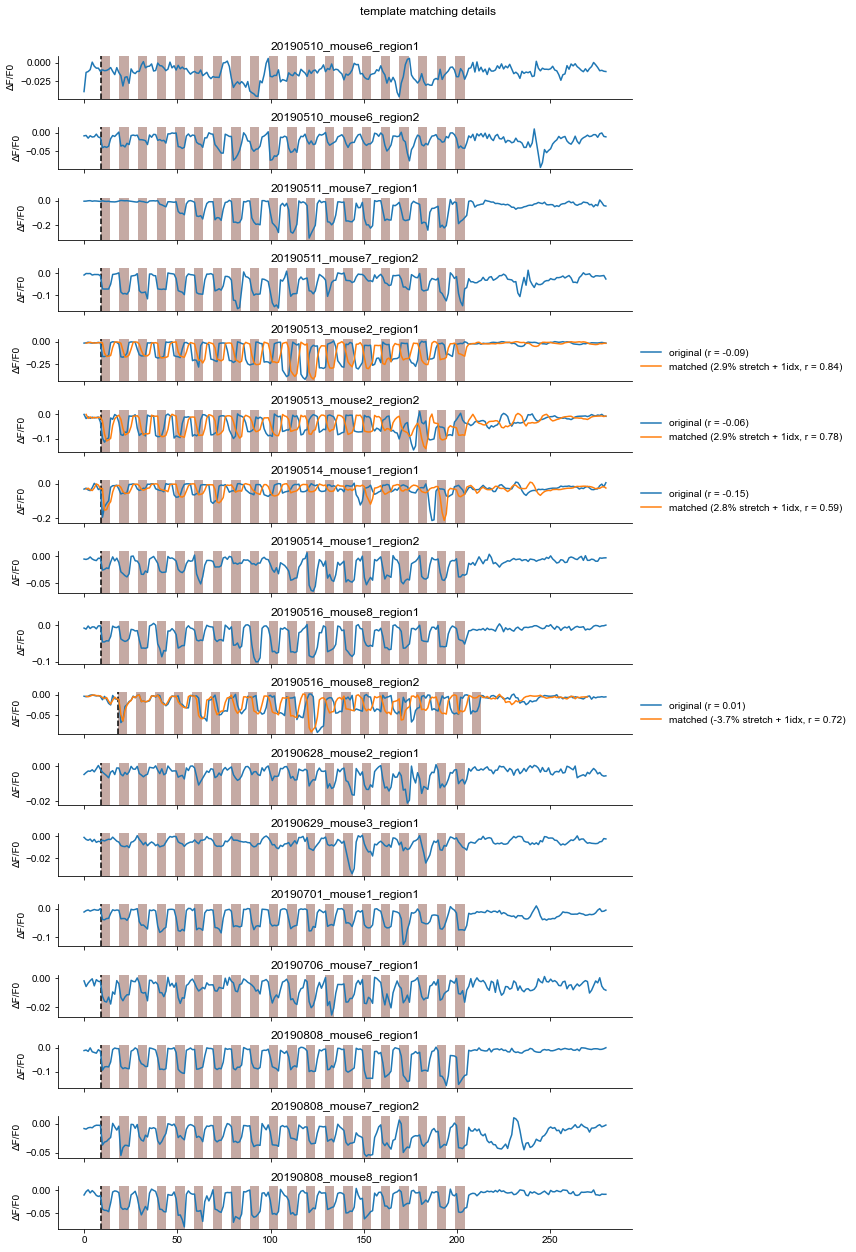

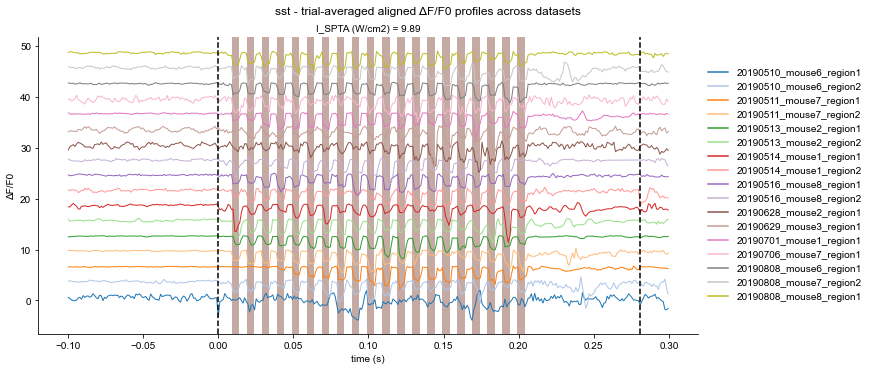

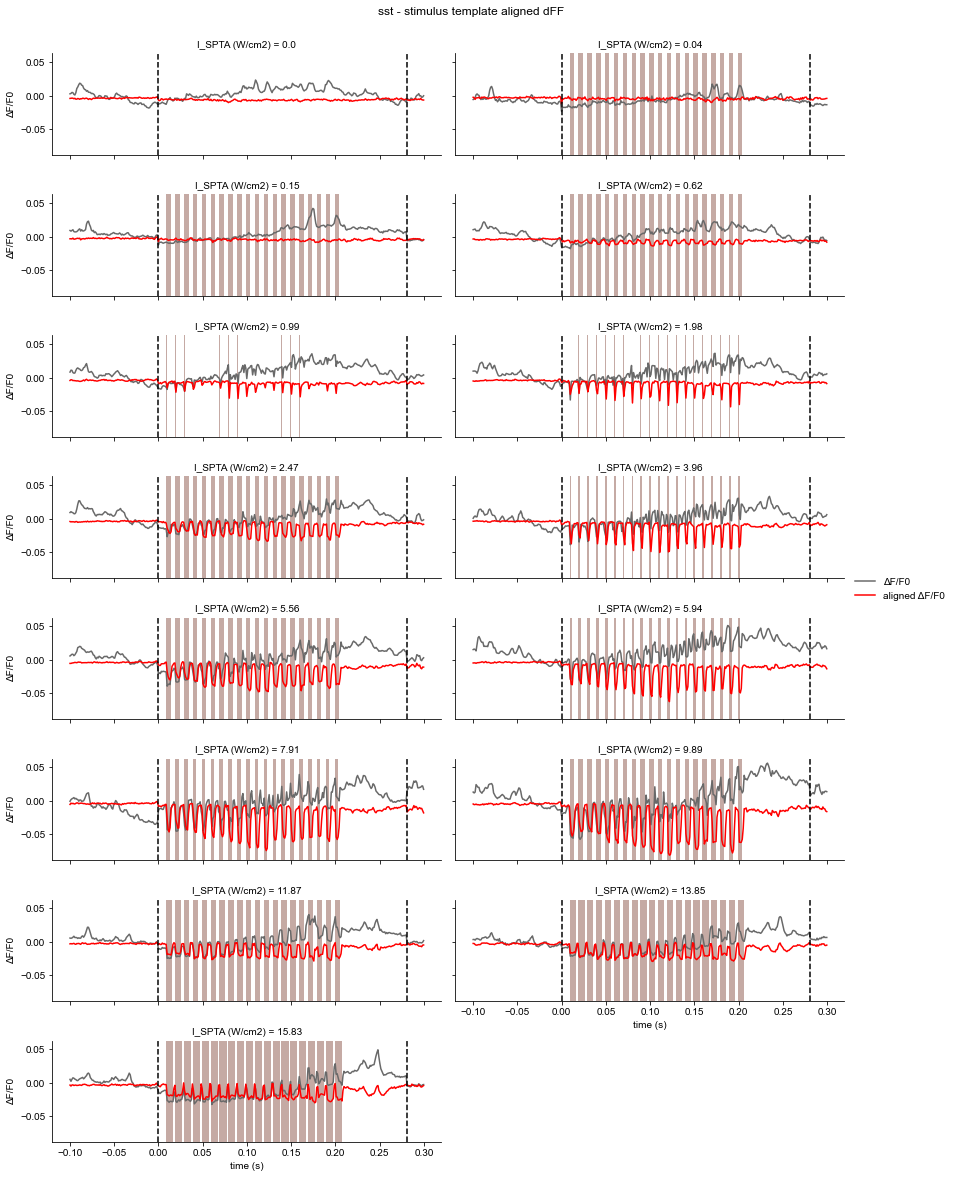

In [15]:
# Flag indicating whether to plot alignment details
plot_details = True

# Extract stimulus-frame trial-averaged dFF signals for reference condition
ref_stim_trialagg_dFF = trialagg_dFF.loc[pd.IndexSlice[:, irun_refcond, fidx.iref]]

# Extract DC for that condition
if group_key == Label.ISPTA:
    DC = get_singleton(ref_stim_trialagg_dFF, Label.DC)  # %
else:
    DC = DC_REF

# Group by dataset
groups = ref_stim_trialagg_dFF.groupby(Label.DATASET)

# Compute matching parameters for each dataset
logger.info(f'computing template matching transformation parameters per dataset on run {irun_refcond}')
match_params = groups.apply(
    lambda df: pd.Series(extract_matching_parameters(
        df[processed_ykey],
        get_stim_trig_delay(dataset_ID),
        dur, PRF, DC, fps, lpf, verbose=True)))
match_params['shift (samples)'] = match_params['shift (samples)'].astype(int)

# Classify transformations "validity" depending on correlation scores
# (either high final correlation, or large increase in correlation)
match_params['valid'] = np.logical_or(
    match_params['opt. corr'] > .5,
    match_params['opt. corr'] - match_params['org. corr'] > .2
)

# Plot matching parameters metrics
title = 'matching stats'
figs[title], axes = plt.subplots(1, 2, figsize=(9, 4))
figs[title].suptitle(title)
hue_order = match_params.index.values
palette = get_discrete_palette(len(hue_order))
for ax in axes:
    sns.despine(ax=ax)
kwargs = dict(
    data=match_params,
    hue=Label.DATASET,
    hue_order=hue_order,
    palette=palette,
)
sns.scatterplot(
    ax=axes[0],
    x='org. corr',
    y='opt. corr',
    legend=False,
    **kwargs
)
axes[0].axline((0, 0), slope=1, c='k', ls='--')
sns.stripplot(
    ax=axes[1],
    x='shift (samples)',
    y='rel. stretch (%)',
    legend='full',
    jitter=.2,
    **kwargs
)
sns.move_legend(axes[1], bbox_to_anchor=(1, 0.6), loc='center left', frameon=False)
figs[title].tight_layout()

# If requested, create figure to plot template matching details 
if plot_details:
    logger.info('plotting details of template matching process per dataset')
    title = 'template matching details' 
    figs[title], axes = plt.subplots(groups.ngroups, 1, figsize=(12, 1 * groups.ngroups), sharex=True)
    for ax, (dataset_ID, gdata) in zip(axes, groups):
        # Set labels
        sns.despine(ax=ax)
        ax.set_title(dataset_ID)
        ax.set_ylabel(Label.DFF)
        
        # Materialize trigger delay
        stimdelay = get_stim_trig_delay(dataset_ID)
        ax.axvline(stimdelay * 1e3, c='k', ls='--')

        # Extract matching parameters
        mparams = match_params.loc[dataset_ID].to_dict()
        rel_stretch, shift = mparams['rel. stretch (%)'] * 1e-2, int(mparams['shift (samples)'])

        # Plot original signal
        t, y = gdata[[Label.TIME, processed_ykey]].values.T
        ax.plot(t * 1e3, y, label=f'original (r = {mparams["org. corr"]:.2f})')

        # If matching transformation is "non-identity" and valid, plot transformed signal
        if (rel_stretch != 0 or shift != 0) and mparams['valid']:
            yopt = shift_signal(stretch_signal(y, 1 + rel_stretch), shift)
            transform_str = f'{rel_stretch * 1e2:.1f}% stretch {"-" if shift < 0 else "+"} {np.abs(shift)}idx'
            ax.plot(t * 1e3, yopt, label=f'matched ({transform_str}, r = {mparams["opt. corr"]:.2f})')
            ax.legend(bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)

        # Materialize stim pulses
        tpulses = get_onoff_times(dur, PRF, DC, onset=stimdelay)
        for tp in tpulses:
            ax.axvspan(*(tp * 1e3), fc='tab:brown', ec=None, alpha=0.5)
        
    figs[title].tight_layout()
    figs[title].suptitle(title, y=1.02)


# Define function to align signals to common stimulus template
def align_signal(y):
    dataset_ID = y.index[0][0]
    rel_stim_delay = get_stim_trig_delay(dataset_ID) - DEFAULT_STIM_TRIG_DELAY  # s
    rel_stim_shift = int(np.round(rel_stim_delay * (fps * lpf)))  # in samples
    rel_stretch, shift, valid = match_params.loc[dataset_ID, ['rel. stretch (%)', 'shift (samples)', 'valid']]
    shift = int(shift)
    if not valid:
        rel_stretch, shift = 0., 0
    if rel_stim_shift != 0:
        shift -= rel_stim_shift  # subtract "difference from default trigger shift" to template-matching shift
    return shift_signal(stretch_signal(y.values, 1 + rel_stretch * 1e-2), shift)

# Align signals
aligned_ykey = f'aligned {Label.DFF}'
trialagg_dFF[aligned_ykey] = trialagg_dFF[processed_ykey].copy()
trialagg_dFF.loc[pd.IndexSlice[:, :, fidx.iref], aligned_ykey] = (
    trialagg_dFF[aligned_ykey].loc[pd.IndexSlice[:, :, fidx.iref]]
    .groupby([Label.DATASET, Label.RUN])
    .transform(align_signal)
    .values
)

# Plot aligned signals around stimulus per dataset
title = f'{mouseline} - trial-averaged {aligned_ykey} profiles across datasets'
figs[title] = plot_rowagg_profiles(
    trialagg_dFF.loc[pd.IndexSlice[:, irun_refcond], :],
    ykey=aligned_ykey,
    tbounds=tbounds['zoomed'],
    hue=Label.DATASET,
    stackhue=True,
    color=refcolor,
    addavg=False,
    height=5,
    aspect=2,
    col_wrap=None,
    **pltkwargs
)
figs[title].suptitle(title, y=1.02)

# Plot corrected signal around stimulus (comparing extended and function-wrapped processing)
title = f'{mouseline} - stimulus template aligned dFF'
figs[title] = plot_rowagg_profiles(
    aggregate_across_datasets(trialagg_dFF),
    ykey=[Label.DFF, aligned_ykey],
    tbounds=tbounds['zoomed'],
    color=['dimgray', refcolor],
    **pltkwargs
)
figs[title].suptitle(title, y=1.02)

# Show matching parameters
match_params

### Inspect pulse-evoked dFF profiles, for each pulse and condition

 2025/10/06 11:51:47: splitting fluorescence signal by pulse across ['dataset', 'run'] combinations
 2025/10/06 11:51:49: interpolating aligned ΔF/F0 values over smooth 50-points pulse-relative time vector...
 2025/10/06 11:51:50: expanding (17 datasets x 15 runs) input dataframe to match (17 datasets x 15 runs x 20 pulses x 50 time w.r.t pulse onset (ms)s) reference dataframe
 2025/10/06 11:51:51: plotting pulse-evoked dFF profiles
 2025/10/06 11:51:51: computing cross-dataset aggregates
 2025/10/06 11:51:53: plotting pulse-evoked dFF profiles
 2025/10/06 11:51:53: computing cross-dataset aggregates


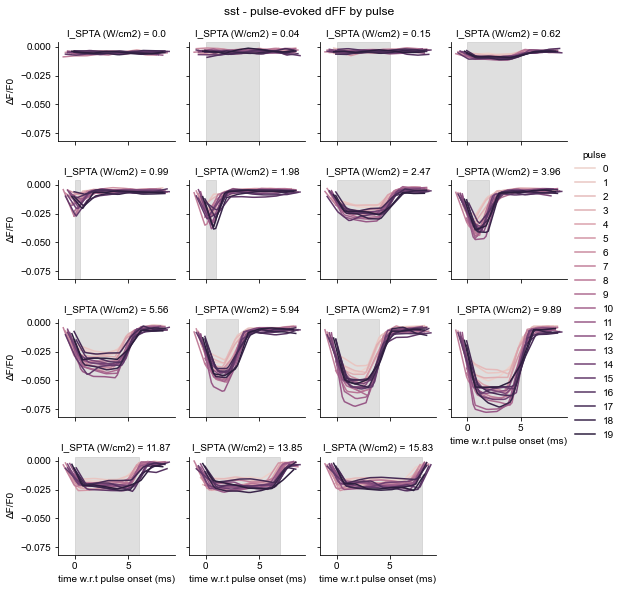

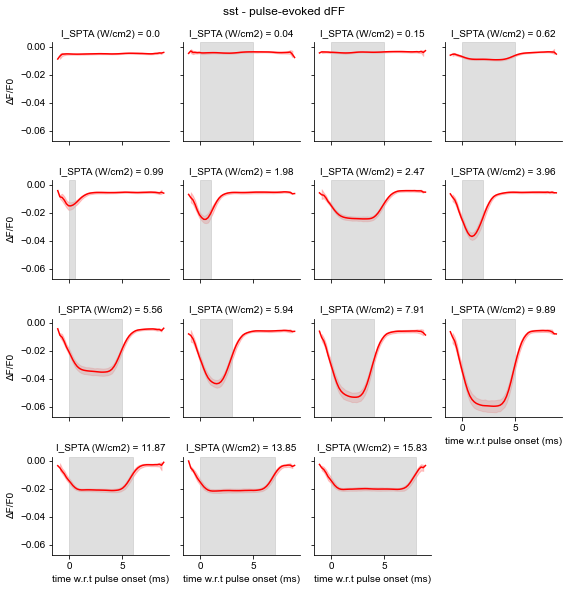

In [16]:
# Input key
ykey = aligned_ykey

# Extract pulse-by-pulse dFF
dFF_by_pulse = split_by_pulse(
    trialagg_dFF[ykey], fidx, fps, dur, PRF, onset=DEFAULT_STIM_TRIG_DELAY if 'aligned' in ykey else 'auto')

# Interpolate values over smooth pulse relative time vector
dFF_by_pulse = interp_over_smooth_pulse_relative_time(dFF_by_pulse)

# Add input parameters 
dFF_by_pulse = free_expand_and_add(info_table[exp_keys], dFF_by_pulse.to_frame())

# # Restrict to datasets that have high DC runs
# has_highDC = trialagg_dFF.groupby(Label.DATASET).apply(lambda df: df[Label.DC].max() >= 60.)
# dFF_by_pulse = dFF_by_pulse.loc[has_highDC[has_highDC].index]

# # Aggregate across pulses
# agg_dFF_by_pulse = aggregate_across_datasets(
#     dFF_by_pulse
#     .groupby([k for k in dFF_by_pulse.index.names if k != Label.PULSE])
#     .agg({
#         ykey: 'mean',
#         **{k: 'first' for k in exp_keys},
#     })
# )

# # For each condition, identify the time of:
# # - last positive derivative (if any) before pulse onset
# # - first negative derivative (if any) after pulse offset
# PW_ms = DC / PRF * 1e1 # ms
# def find_tbounds(df):
#     d = np.sign(df[ykey].diff())
#     trel = df.index.get_level_values(Label.PULSERELTIME)
#     iprepos = np.where(np.logical_and(d >= 0, trel < 0.))[0]
#     istart = iprepos[-1] if iprepos.size > 0 else 0
#     ipostneg = np.where(np.logical_and(d <= 0, trel > PW_ms))[0]
#     istop = ipostneg[0] if ipostneg.size > 0 else -1
#     tbounds = {'start': trel[istart], 'stop': trel[istop]}
#     return pd.Series(tbounds)
# pulse_tbounds = agg_dFF_by_pulse.groupby(group_key).apply(find_tbounds)

# # Extract most restrictive intervals
# pulse_tbounds = pulse_tbounds.agg({'start': 'max', 'stop': 'min'}).values

# Plot "single pulse" dFF profiles
for hue in [Label.PULSE, None]:
    logger.info('plotting pulse-evoked dFF profiles')
    g = sns.relplot(
        kind='line',
        data=aggregate_across_datasets(dFF_by_pulse),
        x=Label.PULSERELTIME,
        y=ykey,
        hue=hue,
        color=refcolor if hue is None else None,
        col=group_key,
        col_wrap=4,
        height=2,
        legend='full' if hue is not None else None
    )
    g.set_axis_labels(Label.PULSERELTIME, Label.DFF)

    # Add shaded areas for pulses
    for colval, ax in g.axes_dict.items():
        DC = col_DC_map.loc[colval]
        if DC > 0:
            PD = (DC * 1e-2) / PRF * 1e3  # ms
            tpulse = np.array([0, PD])
            ax.axvspan(*tpulse, color='silver', alpha=0.5)  # shaded area for pulse duration

    title = f'{mouseline} - pulse-evoked dFF'
    if hue is not None:
        title = f'{title} by {hue}'
    figs[title] = g.figure
    figs[title].suptitle(title, y=1.02)

### Compute aggregate dFF signal by pulse and condition, across datasets 


In [45]:
logger.info('aggregating dFF signals across datasets')
agg_dFF_by_pulse = (
    dFF_by_pulse
    .groupby([k for k in dFF_by_pulse.index.names if k != Label.DATASET])
    .agg({
        ykey: lambda x: x.mean(),
        **{k: 'first' for k in exp_keys},
    })
)

 2025/10/06 13:01:03: aggregating dFF signals across datasets


### Quantify pulse-evoked dFF dip and its dependence on parameters and pulse index

 2025/10/08 09:41:14: computing pulse-evoked dFF dip
 2025/10/08 09:41:16: extracting "noise dip" magnitude from no-stim pulse interval ([0.25 0.26] s)
 2025/10/08 09:41:16: plotting average pulse-evoked dFF dip vs P, ISPPA and DC
 2025/10/08 09:41:16: fitting order 1 polynomial to data
 2025/10/08 09:41:16: fitting results: popt = [0.062, 0.0003], R2 = 0.95
 2025/10/08 09:41:16: best fit type: poly1 (R2 = 0.95)
 2025/10/08 09:41:16: fitting order 1 polynomial to data
 2025/10/08 09:41:16: fitting results: popt = [0.0025, 0.0057], R2 = 0.99
 2025/10/08 09:41:16: best fit type: poly1 (R2 = 0.99)
 2025/10/08 09:41:16: computing relative dip per pulse w.r.t first one
 2025/10/08 09:41:16: plotting relative change in pulse-evoked dFF dip
 2025/10/08 09:41:18: comparison of evoked dip magnitude between 20% and 80% DC conditions (2-sided paired t-test): tstat = 0.88, p = 0.415


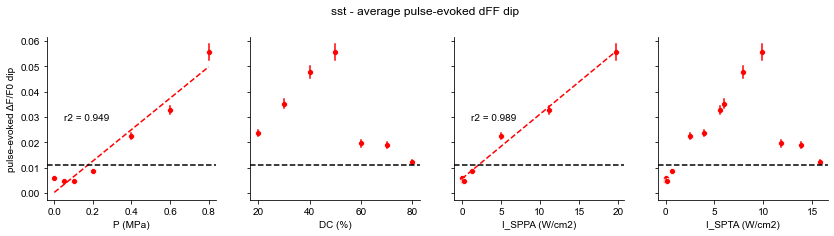

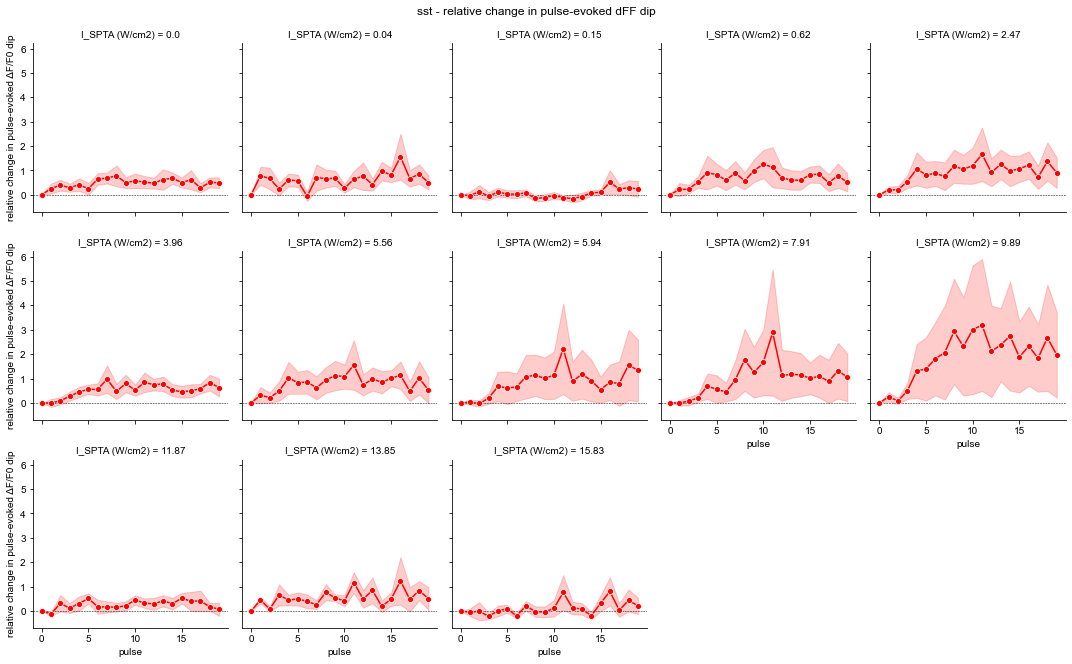

In [55]:
def compute_dip_amplitude(x):
    '''
    Compute amplitude of pulse-evoked dFF dip
    
    :param x: pandas series with dFF signal
    '''
    return x.quantile(.9) - x.quantile(.2)

# Compute pulse-evoked dFF dip, along with P, DC, ISPPA, and grouping variable
logger.info('computing pulse-evoked dFF dip')
dip_ykey = f'pulse-evoked {Label.DFF} dip'
pulse_stats = (
    dFF_by_pulse
    .groupby([k for k in dFF_by_pulse.index.names if k != Label.PULSERELTIME])
    .agg({
        ykey: compute_dip_amplitude,
        **{k: 'first' for k in exp_keys},
    })
    .rename(columns={ykey: dip_ykey})
)

# Extract "noise" dip amplitude from interval outside stimulus burst
noise_tbounds = np.array([dur + 5 / PRF, dur + 6. / PRF])  # s
logger.info(f'extracting "noise dip" magnitude from no-stim pulse interval ({noise_tbounds} s)')
noise_ptp = (
    trialagg_dFF[trialagg_dFF[Label.TIME].between(*noise_tbounds)]
    .groupby([Label.DATASET, Label.RUN])
    [aligned_ykey]
    .agg(lambda x: x.max() - x.min())
    .mean()
)

# For main analysis, restrict to DC >= 20% to avoid sub-sampled dips at low DCs
if group_key == Label.ISPTA:
    pulse_stats = pulse_stats[pulse_stats[Label.DC] >= 20.]

# # Average across pulses for each column grouping value and dataset
aggfuncs = {k: 'mean' if k == dip_ykey else 'first' for k in pulse_stats.columns}
pulseavg_stats = (
    pulse_stats
    .groupby([k for k in pulse_stats.index.names if k != Label.PULSE])
    .agg(aggfuncs)
)

# Plot average pulse-evoked dip vs P, ISPPA and DC
logger.info('plotting average pulse-evoked dFF dip vs P, ISPPA and DC')
title = f'{mouseline} - average pulse-evoked dFF dip'
xkeys = exp_keys if group_key == Label.ISPTA else [group_key]
figs[title], axes = plt.subplots(1, len(xkeys), figsize=(3.5 * len(xkeys), 3), sharey=True)
axes = np.atleast_1d(axes)  # Ensure axes is always an array
figs[title].suptitle(title, y=1.02)
for ax, xkey in zip(axes, xkeys):
    sns.despine(ax=ax)
    if xkey == Label.DC:
        pltdata = pulse_stats[pulse_stats[Label.P] == P_REF] 
    elif xkey in (Label.P, Label.ISPPA):
        pltdata = pulse_stats[pulse_stats[Label.DC] == DC_REF]
    else:
        pltdata = pulse_stats.copy()
    for kwargs in [
            # dict(units=Label.DATASET, estimator=None, alpha=0.5), 
            dict(marker='o', errorbar='se')
        ]:
        sns.lineplot(
            ax=ax,
            data=pltdata,
            x=xkey,
            y=dip_ykey,
            color=refcolor if 'units' not in kwargs else desaturate_color(refcolor),
            err_style='bars' if 'units' not in kwargs else None,
            legend=ax is axes[-1],
            lw=0 if group_key == Label.ISPTA else 1.5,
            **kwargs,
        )
        if xkey in (Label.P, Label.ISPPA):
            yavg = pltdata.groupby(xkey)[dip_ykey].mean()
            x, y = yavg.index.values, yavg.values
            popt, _, r2, fitfunc = compute_fit(x, y, [
                # 'threshold_linear',
                'poly1'
            ])
            xdense = np.linspace(*bounds(pltdata[xkey]), 50)
            ax.text(.1, .5, f'r2 = {r2:.3f}', transform=ax.transAxes, ha='left', va='center')
            ax.plot(
                xdense, fitfunc(xdense, *popt), color=refcolor, ls='--', label=f'{fitfunc.__name__} fit')

    ax.axhline(noise_ptp, color='k', linestyle='--')

# Compute relative dip per pulse w.r.t first one, for each grouping variable and dataset
logger.info('computing relative dip per pulse w.r.t first one')
rel_dip_ykey = f'relative change in {dip_ykey}'
mux = slice_last_dim(pulse_stats.index, 0.)
refdips = pulse_stats.loc[mux, dip_ykey].droplevel(Label.PULSE)
pulse_stats[rel_dip_ykey] = (pulse_stats[dip_ykey] - refdips) / refdips

# Plot relative dip per pulse w.r.t first one, for each grouping variable and dataset
logger.info('plotting relative change in pulse-evoked dFF dip')
title = f'{mouseline} - relative change in pulse-evoked dFF dip'
g = sns.FacetGrid(
    data=pulse_stats.reset_index(),
    col=group_key,
    col_wrap=5,
    height=3,
)
for ax in g.axes_dict.values():
    ax.axhline(0, color='k', linestyle='--', linewidth=0.5)
for kwargs in [
        # dict(units=Label.DATASET, estimator=None, alpha=0.5), 
        dict(marker='o', errorbar='se')
    ]:
    g.map_dataframe(
        sns.lineplot,
        x=Label.PULSE,
        y=rel_dip_ykey,
        color=refcolor if 'units' not in kwargs else desaturate_color(refcolor),
        **kwargs
    )
figs[title] = g.figure
figs[title].suptitle(title, y=1.02)

# For main analysis, compare evoked dip magnitude between 20% and 80% DC conditions
from scipy.stats import ttest_rel
if group_key == Label.ISPTA:
    # Restrict to datasets that have high both 20% and 80% DC runs
    DCtargets = [20., 80.]
    has_highDC = (
        pulseavg_stats
        .groupby(Label.DATASET)
        .apply(lambda df: all(dc in df[Label.DC].values for dc in DCtargets))
    )
    tmp = pulseavg_stats.loc[has_highDC[has_highDC].index]

    # Extract only those runs
    tmp = tmp[tmp[Label.DC].isin(DCtargets)]

    # Test for difference in evoked dip
    vecs = [tmp[tmp[Label.DC] == dc][dip_ykey] for dc in DCtargets]
    tstat, pval = ttest_rel(*vecs)
    logger.info(f'comparison of evoked dip magnitude between 20% and 80% DC conditions (2-sided paired t-test): tstat = {tstat:.2f}, p = {pval:.3f}')

### Inspect relationsip between baseline fluorescence and pulse-evoked dFF change

 2025/10/06 11:52:14: assembling serialized pixel-wise dataset
 2025/10/06 11:52:21: regressing pixel-wise evoked dFF vs baseline F across ['dataset', 'run', 'stim'] combinations


100%|██████████| 387/387 [00:05<00:00, 72.92it/s] 

 2025/10/06 11:52:29: computing correlation coefficient between pixel-wise evoked dFF and baseline F across ['dataset', 'run', 'stim'] combinations



100%|██████████| 387/387 [00:03<00:00, 104.94it/s]

 2025/10/06 11:52:32: computing mean stim-evoked dFF across ['dataset', 'run', 'stim'] combinations


 2025/10/06 11:52:32: expanding (17 datasets x 15 runs) input dataframe to match (17 datasets x 15 runs x 2 stims) reference dataframe


Text(0.5, 1.05, 'stats for stim evoked ΔF/F0 vs. F0')

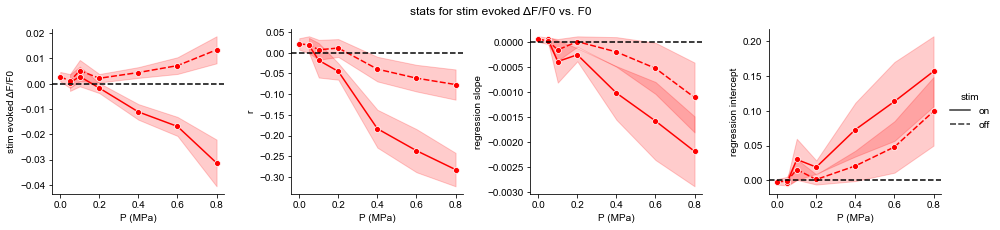

In [18]:
# Plot pixel-wise stim-evoked dFF change vs baseline fluorescence, with correlation and regression
logger.info('assembling serialized pixel-wise dataset')
pixelwise_df = pd.DataFrame({
    f'baseline {Label.F}': Fbase.loc[:, np.arange(lpf)].stack(),
    f'stim evoked {Label.DFF}': stim_evoked_dFF.loc[:, np.arange(lpf)].stack(),
    'stim': stim_mask.loc[:, np.arange(lpf)].stack()
})
pixelwise_df['stim'] = pixelwise_df['stim'].map({0: 'off', 1: 'on'})

# Groupby by dataset, run and stim on/off
gby = [Label.DATASET, Label.RUN, 'stim']
groups = pixelwise_df.groupby([Label.DATASET, Label.RUN, 'stim'])

# Compute linear regression of evoked dFF vs Fbase
logger.info(f'regressing pixel-wise evoked dFF vs baseline F across {gby} combinations')
stimframe_stats = (groups
    .progress_apply(lambda x: mylinregress(x[f'baseline {Label.F}'], x[f'stim evoked {Label.DFF}']))
    .add_prefix('regression ')
)

# Compute correlation coefficient of evoked dFF vs Fbase
logger.info(f'computing correlation coefficient between pixel-wise evoked dFF and baseline F across {gby} combinations')
stimframe_stats['r'] = groups.progress_apply(
    lambda x: pearsonr(x[f'baseline {Label.F}'], x[f'stim evoked {Label.DFF}']).statistic)

# Compute mean stim-evoked dFF in "stim-on" and "stim-off" pixels
logger.info(f'computing mean stim-evoked dFF across {gby} combinations')
stimframe_stats[f'stim evoked {Label.DFF}'] = groups[f'stim evoked {Label.DFF}'].mean()

# Add relevant info_table keys
stimframe_stats = free_expand_and_add(info_table[exp_keys], stimframe_stats)

# Plot stats vs relevant xkey
ykeys = [f'stim evoked {Label.DFF}', 'r', 'regression slope', 'regression intercept']
figs['pixelwise stats'], axes = plt.subplots(1, len(ykeys), figsize=(3.5 * len(ykeys), 3), sharex=True)
pltdata = stimframe_stats[stimframe_stats[Label.DC] == DC_REF] if group_key == Label.ISPTA else stimframe_stats.copy()
for ax, yk in zip(axes, ykeys):
    sns.despine(ax=ax)
    sns.lineplot(
        ax=ax,
        data=pltdata,
        x=Label.P if group_key == Label.ISPTA else group_key,
        y=yk,
        style='stim',
        style_order=['on', 'off'],
        color=refcolor,
        errorbar='se',
        marker='o',
        # units=Label.DATASET, estimator=None,
    )
    ax.axhline(0, c='k', ls='--')
for ax in axes[:-1]:
    ax.get_legend().remove()
sns.move_legend(
    axes[-1], 'center left', frameon=False, title='stim', bbox_to_anchor=(1, 0.5))
figs['pixelwise stats'].tight_layout()
figs['pixelwise stats'].suptitle(f'stats for stim evoked {Label.DFF} vs. F0', y=1.05)

### Save figures

In [19]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=f'intraframe_{mouseline}_{analysis_type}_analysis')

 2025/10/06 11:52:33: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2025.10.06/figs_intraframe_sst_main_analysis.pdf:


100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


### Notify upon completion

In [20]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'intra-pulse analysis notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 2025/10/06 11:52:43: intra-pulse analysis notebook completed in 0:02:18.327854 s
